In [1]:
import src
import numpy as np
import matplotlib.pyplot as plt
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error

## Prepare the option circuit


                 ┌───────────┐ ┌───┐┌────────────┐┌───┐          »
           i_0: ─┤ Ry(1.682) ├─┤ X ├┤ Ry(1.3513) ├┤ X ├──────────»
                ┌┴───────────┴┐└─┬─┘└────────────┘└─┬─┘┌───┐     »
           i_1: ┤ Ry(0.93287) ├──■──────────────────■──┤ X ├──■──»
                └────┬───┬────┘                        └───┘  │  »
a_comparator_0: ─────┤ X ├────────────────────────────────────■──»
                     ├───┤                                  ┌─┴─┐»
a_comparator_1: ─────┤ X ├──────────────────────────────────┤ X ├»
                 ┌───┴───┴────┐                             └───┘»
      a_payoff: ─┤ Ry(1.5508) ├──────────────────────────────────»
                 └────────────┘                                  »
«                                                                 
«           i_0: ────────────────────────■────────────────────────
«                      ┌───┐             │                        
«           i_1: ──────┤ X ├─────────────┼───────────────■────

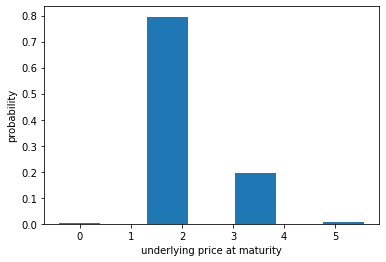

In [2]:
#Set the parameters
params={'n':2, #number of state preparation qubits
        'S':2, #spot price
        'K':2, #strike #price
        'vol':0.3, #volatility
        'r': 0.05, #risk-free rate
        't':1, #time to maturity
        }
option=src.EuropeanCallOption(**params)
plt.bar(option.x,option.probs)
#We could look at other quantitites, curves, e.g., the payoff and it's numerical approximation
#plt.plot(option.x, option.payoff(option.x))
plt.xlabel("underlying price at maturity")
plt.ylabel("probability")
print(option.circuit())

## Prepare the amplitude estimation circuits


In [3]:
qc = option.circuit(barriers=False)
#Make a custom zero reflection operator that reuses the comparator ancillas
zero_reflection = src.QAError.zero_reflection(qc.qregs, 0,2,1, "v-chain-dirty")
#The oracle of the Grover's algorithm
oracle = src.QuantumCircuit(2 * option.n + 1)
oracle.z(2 * option.n)
#Create the QAError class that can give you the necessary circuits, the errors are also implemented in this
qae = src.QAError(oracle, qc, [2*option.n], zero_reflection=zero_reflection, basis_gates=["rz","sx","x","cx"], device="CPU")
#Prepare the circuits for different powers of the Grover operator
qae.circuit_sequence([0,1,2,3])

## Calculate the Cramér-Rao error bound for known Grover operator error rate


In [4]:
#Define the noise model
error1=1e-5 #1-qubit gate error
error2=1e-4 #2-qubit gate error
noise_model = NoiseModel(basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(error1, 1), 'id')
noise_model.add_all_qubit_quantum_error(depolarizing_error(error1, 1), 'sx')
noise_model.add_all_qubit_quantum_error(depolarizing_error(error1, 1), 'x')
noise_model.add_all_qubit_quantum_error(depolarizing_error(error2, 2), 'cx')
#Fit the  Grover operator coherence probability on ten linearly increasing Grover steps
pQ = qae.fit_pcoh(kmax=10,noise_model = noise_model)[0][1]

In [5]:
#Choose the schedule type
cr = src.CRCalculatorExponential(N=100, t0 = np.arcsin(np.sqrt(option.ideal_prob())))
#Set the previously calculated Grover operator coherence probability (error_rate = 1-coherence_probability)
cr.set_pcoh(pQ)
#set the maximum of the schedule
cr.set_schedule(mkmax=1000)
print("The schedule is:", cr.schedule)
print("The Cramér-Rao error bounds of the probability for N=100 with increasing schedule steps are:", cr.get_errors())
print("The same error bounds on the price are:", option.error_to_price(cr.get_errors()))

The schedule is: [  0   1   2   4   8  16  32  64 128 256 512]
The Cramér-Rao error bounds of the probability for N=100 with increasing schedule steps are: [0.04999344 0.028635   0.01474236 0.00791894 0.004169   0.00196076
 0.00064397 0.00047462 0.00038419 0.00035917]
The same error bounds on the price are: [7.51799862 4.30612291 2.21695181 1.19084845 0.62693356 0.29485838
 0.09684045 0.07137283 0.05777506 0.05401258]


## Calculate the systematic error

In [6]:
#Simply substract the numerical and analytic price.
print("The systematic error is:",option.ideal_price()-option.BS_price())
print("The analytic option price (Black-Sholes model):", option.BS_price())

The systematic error is: 0.0016687926644976536
The analytic option price (Black-Sholes model): 0.2846250957197164


# We can solve the same problem with the Fourier series base function application

In [15]:
kmax = 5
optionF=src.EuropeanCallOptionFourier(**params)
qc_0 = optionF.circuit(fourier_n=0, fourier_beta=np.pi)
qc_cos = [optionF.circuit(fourier_n=i, fourier_beta=0) for i in range(1,kmax+1)]
qc_sin = [optionF.circuit(fourier_n=i, fourier_beta=np.pi/2) for i in range(1,kmax+1)]
#For amplitude estimation we have to prepare a QAE sequence for every circuit. For simplicity here we only calculate the probability
term_0 = src.simulate_prob(qc_0,[2*params['n']])[1]
terms_cos = np.array([src.simulate_prob(qc,[2*params['n']])[1] for qc in qc_cos])
terms_sin = np.array([src.simulate_prob(qc,[2*params['n']])[1] for qc in qc_sin])
price = optionF.probs_to_price(term_0, terms_cos, terms_sin)

In [16]:
print("The price encoded by the quantum circuit:",price)
print("The price from the Black-Sholes model:", optionF.BS_price())

The price encoded by the quantum circuit: 0.2850849322155017
The price from the Black-Sholes model: 0.2846250957197164
